In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Import and Clean Data

### Drop NaN Values and Fix Production Companies/Genres

In [2]:
df = pd.read_csv("Data_API/TMDB_movie_dataset_v11.csv")

In [3]:
df = df.dropna(subset=["budget","revenue", "production_companies"])
df = df[df["budget"] > 100000]

### Adjust for inflation

### Fix Production Companies, Genre, and Regions

In [4]:
df["production_companies"] = df["production_companies"].str.split(",")
df = df.explode("production_companies")
df["production_companies"] = df["production_companies"].str.strip()

In [5]:
df["genres"] = df["genres"].str.split(",")
df = df.explode("genres")
df["genres"] = df["genres"].str.strip()

In [6]:
df["production_countries"] = df["production_countries"].str.split(",")
df = df.explode("production_countries")
df["production_countries"] = df["production_countries"].str.strip()

## Feature Engineering:
### Calculate ROI

In [7]:
df["roi"] = (df["revenue"] - df["budget"])/df["budget"]

### Create List of Top American Studios

In [8]:
df = df[df["production_countries"] == "United States of America"]
unique_movies = df.drop_duplicates(subset=["title", "production_companies"])
unique_movies = unique_movies.groupby("production_companies").count().sort_values("id", ascending=False)
top_studios = unique_movies.loc[unique_movies["id"] >= 50].index

### Filter Movies for Major Studios

In [9]:
df = df[df["production_companies"].isin(top_studios)]

In [10]:
df = df[["title", "budget", "revenue", "genres", "production_companies", "roi"]]

### Get Rotten Tomatoes Data

## Analyze Data
### Visualization 1: Production Budgets and ROIs

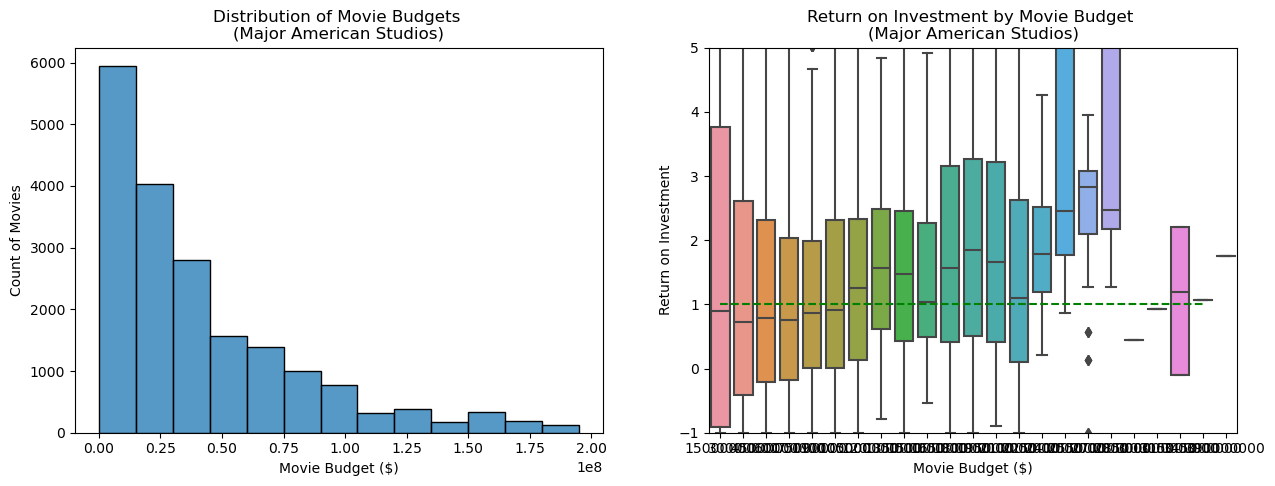

In [60]:
fig, ax = plt.subplots(1,2, figsize=[15, 5])
sns.histplot(data=df, x="budget", bins=np.arange(0,210000000,15000000), ax=ax[0])
ax[0].set_title("Distribution of Movie Budgets \n(Major American Studios)")
ax[0].set_xlabel("Movie Budget ($)")
ax[0].set_ylabel("Count of Movies")

df["budget_bin"] = (df["budget"] // 15000000 + 1) * 15000000 
sns.boxplot( data=df, x="budget_bin", y="roi", ax=ax[1])
ax[1].set_ylim(-1, 5)
ax[1].hlines(y=1, xmin=0, xmax=21, color="g", linestyles="dashed" );

ax[1].set_title("Return on Investment by Movie Budget \n(Major American Studios)")
ax[1].set_xlabel("Movie Budget ($)")
ax[1].set_ylabel("Return on Investment")


fig.savefig("Presentation/Images/overview_studios.png")


/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_16227/1412977153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[df2["budget"] < 2000000, "Budget Group"] = 1


(-2.0, 5.0)

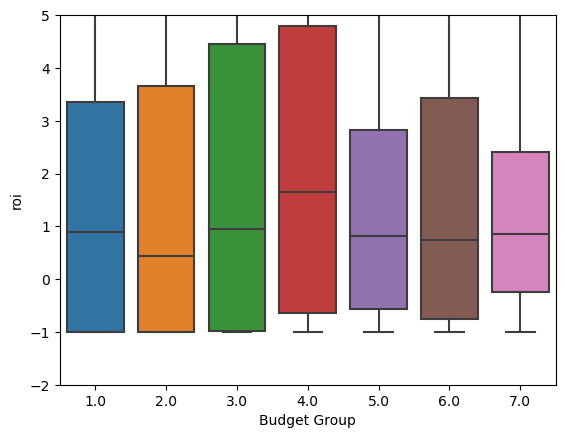

In [11]:
df2 = df.drop_duplicates(subset=["title"])
df2.loc[df2["budget"] < 2000000, "Budget Group"] = 1
df2.loc[(df2["budget"] >= 2000000) & (df2["budget"] < 4000000), "Budget Group"] = 2
df2.loc[(df2["budget"] >= 4000000) & (df2["budget"] < 6000000), "Budget Group"] = 3
df2.loc[(df2["budget"] >= 6000000) & (df2["budget"] < 8000000), "Budget Group"] = 4
df2.loc[(df2["budget"] >= 8000000) & (df2["budget"] < 10000000), "Budget Group"] = 5
df2.loc[(df2["budget"] >= 10000000) & (df2["budget"] < 12000000), "Budget Group"] = 6
df2.loc[(df2["budget"] >= 12000000), "Budget Group"] = 7

fig, ax = plt.subplots()
sns.boxplot(data=df2, x="Budget Group", y="roi", ax=ax);
ax.set_ylim(-2, 5)

### Visualization 2: Average ROI vs. Production Company

In [12]:
df.loc[(df["production_companies"] == "20th Century Fox") & (df["budget"] < 12000000) & (df["budget"] > 2000000),"roi"].mean()

3.1431033553788037

In [13]:
df3 = df.drop_duplicates(subset=["title","production_companies"])
production_roi = df3.loc[(df3["budget"] < 12000000) & (df3["budget"] > 2000000),["production_companies","roi"]].groupby("production_companies").mean().sort_values("roi", ascending=False)

In [14]:
production_roi.index

Index(['Dune Entertainment', 'Blumhouse Productions', 'Amblin Entertainment',
       'Legendary Pictures', 'Working Title Films', 'Paramount',
       'Universal Pictures', 'DreamWorks Pictures',
       'PolyGram Filmed Entertainment', 'Original Film', 'Regency Enterprises',
       'Focus Features', 'Warner Bros. Pictures', 'Walt Disney Pictures',
       'Film4 Productions', 'Sony Pictures', 'Touchstone Pictures',
       'Lionsgate', 'United Artists', 'New Line Cinema', 'Relativity Media',
       'Miramax', '20th Century Fox', 'Screen Gems', 'Summit Entertainment',
       'Mandate International', 'Columbia Pictures', 'Orion Pictures',
       'Stage 6 Films', 'Fox Searchlight Pictures', 'Scott Rudin Productions',
       'Imagine Entertainment', 'Davis Entertainment', 'Metro-Goldwyn-Mayer',
       'The Weinstein Company', 'StudioCanal', 'Castle Rock Entertainment',
       'TriStar Pictures', 'TSG Entertainment', 'Hollywood Pictures', 'Canal+',
       'RKO Radio Pictures', 'Silver Pictures

<Axes: xlabel='production_companies', ylabel='roi'>

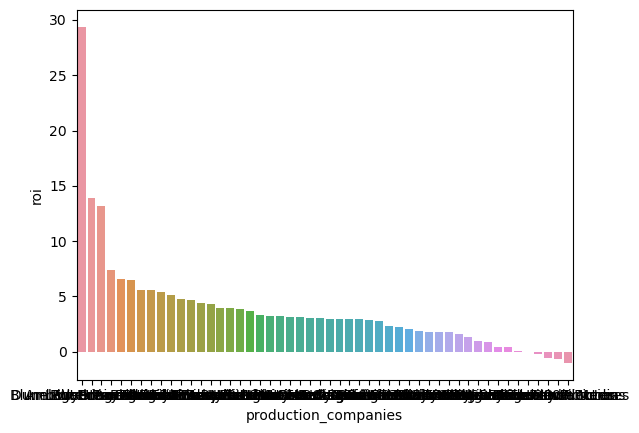

In [15]:
sns.barplot(production_roi, x=production_roi.index, y=production_roi["roi"])

In [16]:
df.loc[(df["production_companies"] == "Universal Pictures") & (df["budget"] < 12000000),["title","budget", "roi"]]

,title,budget,roi
84,Split,9000000,29.939373
84,Split,9000000,29.939373
252,E.T. the Extra-Terrestrial,10500000,74.520524
252,E.T. the Extra-Terrestrial,10500000,74.520524
252,E.T. the Extra-Terrestrial,10500000,74.520524
...,...,...,...
314481,Riders of Death Valley,1000000,-1.000000
842190,The Impatient Maiden,225000,-1.000000
842190,The Impatient Maiden,225000,-1.000000
884556,Joseph DiDonato: Unstoppable Tour,3000000,-1.000000


### Visualization 3: Successful Genres

Half of the successful low-budget movies made by these production companies are either comedy, drama, action, or thrillers.

In [17]:
target_studios = ["Paramount", "Universal Pictures", "Warner Bros. Pictures"]

<Axes: xlabel='genres'>

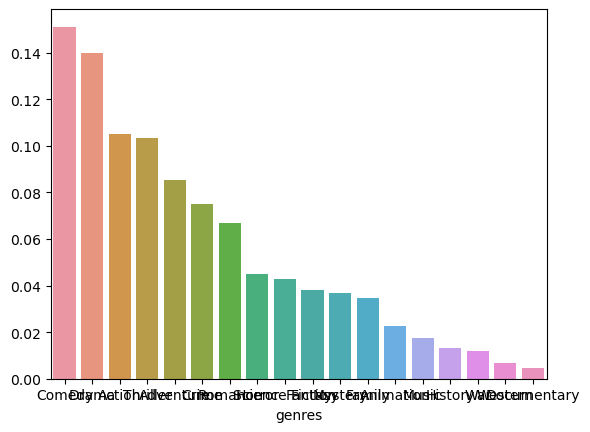

In [18]:
genres_count_successful = df.loc[(df["production_companies"].isin(target_studios)) & (df["roi"] > 1),"genres"].value_counts()
genres_count_successful = genres_count_successful/genres_count_successful.sum()
sns.barplot(x=genres_count_successful.index, y=genres_count_successful.values)

In [19]:
target_genre = list(genres_count_successful[:4].index)
target_genre

['Comedy', 'Drama', 'Action', 'Thriller']

### Visualization 4: 

In [20]:
df.loc[(df["production_companies"].isin(target_studios)) & (df["genres"].isin(target_genre)) & (df["roi"] > 1) & (df["budget"]<12000000)]

,title,budget,revenue,genres,production_companies,roi
53,The Godfather,6000000,245066411,Drama,Paramount,39.844402
84,Split,9000000,278454358,Thriller,Universal Pictures,29.939373
191,A Clockwork Orange,2200000,26589000,Drama,Warner Bros. Pictures,11.085909
303,Jaws,7000000,470653000,Thriller,Universal Pictures,66.236143
408,The Purge,3000000,89328627,Thriller,Universal Pictures,28.776209
...,...,...,...,...,...,...
140901,Caddyshack: The 19th Hole,6000000,60000000,Comedy,Warner Bros. Pictures,9.000000
180138,The Singing Fool,388000,5916000,Drama,Warner Bros. Pictures,14.247423
311159,The Miracle Man,120000,3600000,Drama,Paramount,29.000000
762564,On Trial,130000,1454000,Drama,Warner Bros. Pictures,10.184615
